In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer

# UTILITY FUNCTIONS FOR PREPROCESSING AND OTHER TASKS

In [27]:
def preprocess_tweet(text):
    #Convert to lowercasetext = text.lower();
    text=text.lower();
    #Regex to remove unecessary charcters
    text = re.sub(r'http\S+|[^a-zA-Z\s]', '', text).strip()
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join the processed tokens back into a text string
    processed_text = ' '.join(tokens)
    return processed_text
    

# Loading Data


In [12]:
train_df=pd.read_csv("Corona_NLP_train.csv", encoding='latin1')

train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [13]:
test_df=pd.read_csv("Corona_NLP_test.csv", encoding='latin1')

test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [14]:
print("Information about Training Data\n")
train_df.info()

print("Information about Testing Data\n")
test_df.info()

Information about Training Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
Information about Testing Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 n

In [15]:
print("Training Shape: ", train_df.shape)
print("Testing Shape: ", test_df.shape)

Training Shape:  (41157, 6)
Testing Shape:  (3798, 6)


In [16]:
df = pd.concat([train_df, test_df])
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

# Pre-Processing Data

In [63]:
test_df.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [66]:
#missing values in lOCATION replaced with string 'Unknown'
test_df['Location'].fillna('Unknown', inplace=True)

train_df['Location'].fillna('Unknown', inplace=True)

print(test_df.isnull().sum())

print(train_df.isnull().sum())

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


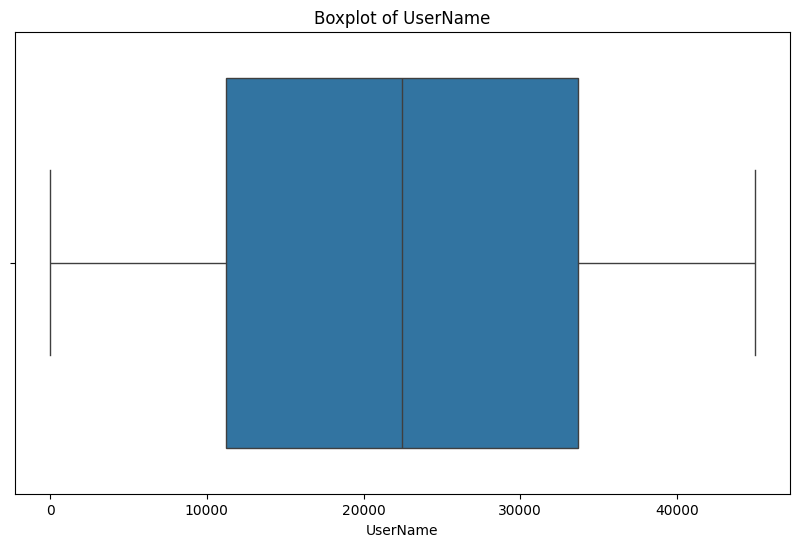

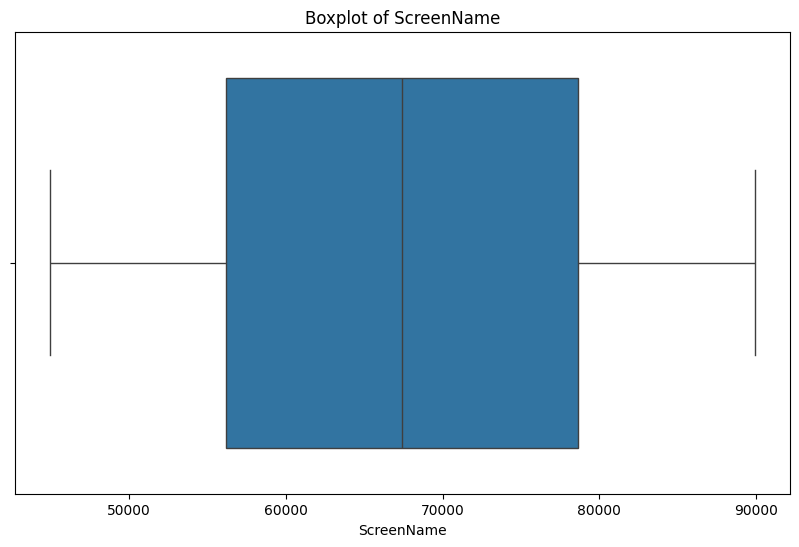

In [17]:
numerical = list(train_df.select_dtypes(include=['int64', 'float64']).columns)

# Boxplot for each variable in numerical list

for col in numerical:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

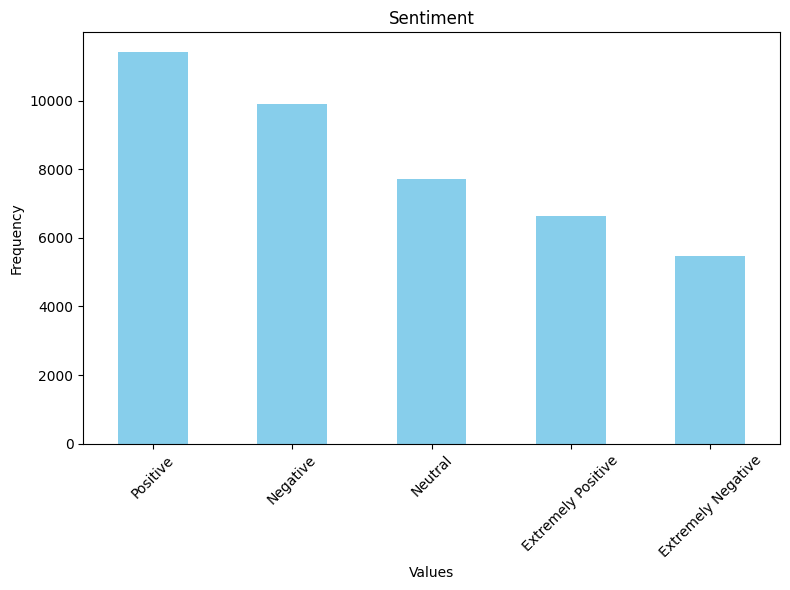

In [18]:
value_counts = train_df['Sentiment'].value_counts()

plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Sentiment')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
from sklearn.preprocessing import LabelEncoder
#drop unecessary columns
train_df.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt'], inplace = True)

test_df.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt'], inplace = True)

label_encoder = LabelEncoder()

train_df['sentiment_encoded'] = label_encoder.fit_transform(train_df['Sentiment'])
test_df['sentiment_encoded'] = label_encoder.fit_transform(test_df['Sentiment'])

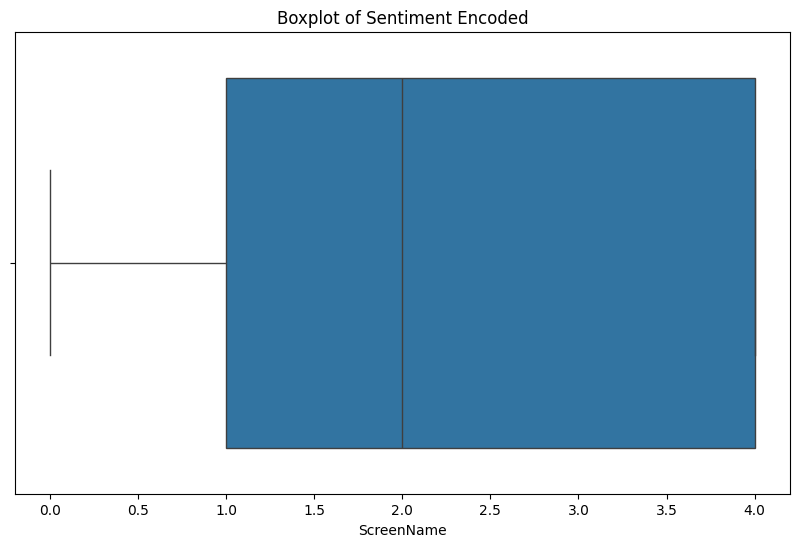

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df['sentiment_encoded'])
plt.title('Boxplot of Sentiment Encoded')
plt.xlabel(col)
plt.show()

In [35]:
#Applying Preprocessing Steps to our target column

train_df["Final_Tweet"]=train_df['OriginalTweet'].apply(preprocess_tweet)
test_df["Final_Tweet"]=test_df['OriginalTweet'].apply(preprocess_tweet)

In [36]:
train_df.head()

,OriginalTweet,Sentiment,sentiment_encoded,Final_Tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,3,menyrbie philgahan chrisitv
1,advice Talk to your neighbours family to excha...,Positive,4,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,Positive,4,coronavirus australia woolworth give elderly d...
3,My food stock is not the only one which is emp...,Positive,4,food stock one empty please dont panic enough ...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,ready go supermarket covid outbreak im paranoi...


In [37]:
test_df.head()

,OriginalTweet,Sentiment,Final_Tweet
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...
1,When I couldn't find hand sanitizer at Fred Me...,Positive,couldnt find hand sanitizer fred meyer turned ...
2,Find out how you can protect yourself and love...,Extremely Positive,find protect loved one coronavirus
3,#Panic buying hits #NewYork City as anxious sh...,Negative,panic buying hit newyork city anxious shopper ...
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,toiletpaper dunnypaper coronavirus coronavirus...


In [38]:
#After Preprocessing we dont need Original_Tweet Column so we drop it
if 'OriginalTweet' in train_df.columns:
 train_df.drop(columns=['OriginalTweet'], axis=1, inplace=True)
if 'OriginalTweet' in test_df.columns:
 test_df.drop(columns=['OriginalTweet'], axis=1, inplace=True)

## Apllying Padding

In [44]:
#All tweet lengths
tweet_lengths = [len(tweet) for tweet in train_df['Final_Tweet']]
max_length = max(set(tweet_lengths), key=tweet_lengths.count) + 10

#padding seqeunce for both training and test data
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

max_length

180

## Model Architecture

In [48]:
#tokeniser splits our tweets into individual words/subwords
tokenizer = Tokenizer()

#this step builds vocabulary of the tokenizer
tokenizer.fit_on_texts(train_df['Final_Tweet'])

#this step encodes each word of each tweet into an integer sequence 
X_train = tokenizer.texts_to_sequences(train_df['Final_Tweet'])
X_test = tokenizer.texts_to_sequences(test_df['Final_Tweet'])

In [51]:
vocab_size = len(tokenizer.word_index)
#+1 for the padding token
vocab_size+=1

#represents the dimensionality of the word vectors (holding semantic meaning) to be used by model
embedding_dim = 100

#Set maxlen based on the length of your input sequences
maxlen = max(len(seq) for seq in X_train)

#we have 5 classes of Sentiment
num_classes = len(label_encoder.classes_)